In [53]:
import pickle
import torch.utils.data
import torch
from seagul.rl.run_utils import load_model, load_workspace
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
from seagul.rl.models import PpoModel, switchedPpoModel
from seagul.nn import MLP
import gym
torch.set_default_dtype(torch.double)

#load_path = './data/mj_baseline7/acrobot73380899'
#load_path = './data/inv_pend/acrobot_116_3'
load_path = './data/acrobot_switch4/r3_long_seed_7'

In [22]:
# hard coded gate for debugging

#def gate(state):
#    if len(state.shape) == 1:
#        return (((140 * pi / 180 < state[0] < pi) and state[1] <= 0) or (
#                (pi < state[0] < 220 * pi / 180) and state[1] >= 0))
#    else:
#        ret  = ((((140 * pi / 180 < state[:,0]) & (state[:,0] < pi)) & (state[:,1] <= 0))
#               | ((pi < state[:,0]) & (state[:,0] < 220 * pi / 180) & (state[:,1] >= 0)))
#        return torch.as_tensor(ret,dtype=torch.double).reshape(-1,1)


#def gate(state):
#    if len(state.shape) == 1:
#        return ((140 * pi / 180 < state[0] < pi) or (pi < state[0] < 220 * pi / 180))
#    else:
#        ret  = ( ((140 * pi / 180 < state[:,0]) & (state[:,0] < pi)) | ((pi < state[:,0]) & (state[:,0] < 220 * pi / 180)))
#
#        return torch.as_tensor(ret,dtype=torch.double).reshape(-1,1)
    
    
def control(env,q):
    k = np.array([-1000, 1000, -10, -10])
    goal = np.copy(env.state)
    goal[0] -= pi
    return -k.dot(goal)



#input_size

env = gym.make('su_acrobot-v0')
model = switchedPpoModel(
     #policy = MLP(input_size, output_size, num_layers, layer_size, activation),
     policy = torch.load("policy_warm"),
     value_fn = torch.load("value_fn_warm"),
     #MLP(input_size, 1, num_layers, layer_size, activation),
     gate_fn  = torch.load("gate_fn_ac"),
     nominal_policy=control,
     env=env
)

1500000


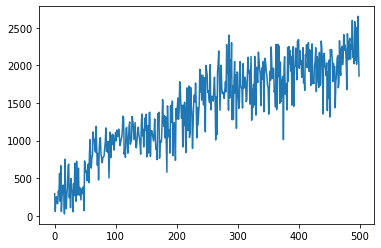

In [48]:
model, env, args, ws = load_workspace(load_path)
plt.plot(ws['avg_reward_hist'])
#plt.plot(ws['a'])
#plt.figure()
#plt.plot(ws['p_loss_hist'])
#plt.figure()
#plt.plot(ws['v_loss_hist'])
print(ws['num_states'])

#plt.figure()
#plt.plot(np.array(ws['ep_path_tensor']))

In [27]:
model, env = load_model(load_path)
data = pd.read_csv(load_path + '/progress.csv')
plt.plot(data['eprewmean'])

plt.figure()
plt.plot(data['policy_loss'])

plt.figure()
plt.plot(data['value_loss'])




KeyError: 'save_path'

1499
[2670.75292964]


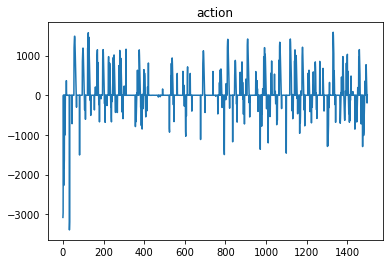

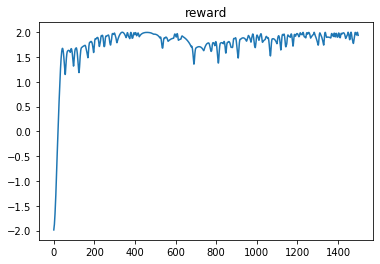

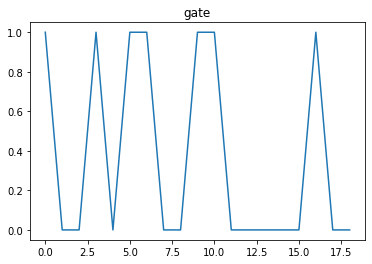

In [52]:
# Acrobot

model.env = env
myenv = env
myenv.num_steps=1500



#model.gate_fn.net_fn = gate
action_hist = np.zeros((myenv.num_steps,1))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))
logp_hist = np.zeros((myenv.num_steps, 1))

#model.action_var = .1
#model.action_var = 1
#model.gate_var = .2

obs = myenv.reset()

for i in range(myenv.num_steps):
        actions, _, _, logp = model.step(obs)
        #actions = np.zeros(1)
        obs, reward, done, _ = env.step(actions)        
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        logp_hist[i,:]   = logp
        #env.render()
        if done:
            break
            
            
gate_hist = [1 if p == 0 else 0 for p in logp_hist]
            
plt.plot(action_hist)
plt.title('action')

plt.figure()
plt.plot(reward_hist)
plt.title('reward')

plt.figure()
plt.plot(gate_hist[1:20])
plt.title('gate')



#plt.figure()
#plt.plot(gate_hist)

# plt.figure()
# plt.plot(state_hist[:,0])
# plt.title("cos(th1)")

# plt.figure()
# plt.plot(state_hist[:,1])
# plt.title("sin(th1)")

# plt.figure()
# plt.plot(state_hist[:,2])
# plt.title("cos(th2)")

# plt.figure()
# plt.plot(state_hist[:,3])
# plt.title("sin(th2)")

# plt.figure()
# plt.plot(state_hist[:,4])
# plt.title("th1 dot")

# plt.figure()
# plt.plot(state_hist[:,5])
# plt.title("th2 dot")


print(i)
print(sum(reward_hist))

In [ ]:
# Cartpole

myenv = env
myenv.num_steps=1500

#model.gate_fn.net_fn = gate
action_hist = np.zeros((myenv.num_steps,1))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))

obs = env.reset()

for i in range(myenv.num_steps):
        actions, _, _, _ = model.step(obs)
        #actions = np.zeros(1)
        obs, reward, done, _ = env.step(actions)        
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        #env.render()
        if done:
            break

plt.plot(action_hist)
plt.figure()
plt.plot(reward_hist)

plt.figure()
plt.plot(state_hist[:,0])
plt.title("theta")

plt.figure()
plt.plot(state_hist[:,1])
plt.title("x")


plt.figure()
plt.plot(state_hist[:,2])
plt.title("theta dot")


plt.figure()
plt.plot(state_hist[:,3])
plt.title("xdot ")


print(i)
print(sum(reward_hist))

In [ ]:
def control(env, q):
    k1 = 140.560
    k2 = -3.162*.1
    k3 = 41.772
    k4 = 0#-8.314
    u = -4*(k1 * (q[0] - pi) + k2 * q[1] + k3 * q[2] + k4 * q[3])
    return u

myenv = env
myenv.num_steps=2000

#model.gate_fn.net_fn = gate
action_hist = np.zeros((myenv.num_steps,1))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))
path_hist = np.zeros((myenv.num_steps,1))

obs = env.reset()
#env.state[0] = np.pi
model.hyst_state = 0

for i in range(myenv.num_steps):
        if ((155 * pi/180 < obs[0] < 220 * pi/180)):
            actions = np.array(control(env, obs))/50
            #actions = np.zeros(1)
            path_hist[i]  = 1
        
        else:
            actions, _, _, _ = model.step(obs)
            path_hist[i] = 0
            
        
        actions = np.clip(actions, -75, 75)
        #actions = np.zeros(1)
        obs, reward, done, _ = env.step(actions)        
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        #env.render()
        if done:
            break

plt.plot(action_hist)
plt.title('action')


plt.figure()
plt.plot(path_hist)

plt.figure()
plt.plot(state_hist[:,0])
plt.title("theta")

plt.figure()
plt.plot(state_hist[:,1])
plt.title("x")


plt.figure()
plt.plot(state_hist[:,2])
plt.title("theta dot")


plt.figure()
plt.plot(state_hist[:,3])
plt.title("xdot ")

print(i)
print(sum(reward_hist))

In [ ]:
env.state[0] = np.pi
env.state[1] = 1
env.render()

In [ ]:
-(np.cos(env.state[0]) + np.cos(env.state[0] + env.state[1]))

In [ ]:
np.cos(env.state[0])

In [ ]:
np.cos(env.state[1])

In [ ]:
env.action_space.high

In [ ]:
pprint(list(ws.keys()))

In [ ]:
action_hist

In [ ]:
model.policy.state_dict()